In [1]:
import os
import pandas as pd

root_pth = '/home/ddon0001/PhD/experiments/error_sampling_ws_fa_fe/'
all_ds_path = '/home/ddon0001/PhD/experiments/scaled/no_merges_all/solution_edges_datasets_with_FP_WS_FA_FE.csv'
all_ds = pd.read_csv(all_ds_path)[['ds_name', 'solution_incorrect']]
ds_names = all_ds['ds_name'].unique()
plot_order = all_ds[all_ds.solution_incorrect].ds_name.value_counts().index

original_metrics = pd.read_csv(
    '/home/ddon0001/PhD/experiments/as_ctc/no_merges/no_merge_metrics.csv',
    sep=';'
)[['dataset', 'LNK', 'BIO(0)']]
trackastra_metrics = pd.read_csv(
    '/home/ddon0001/PhD/experiments/trackastra/trackastra_metrics.csv',
    sep=';'
)[['dataset', 'LNK', 'BIO(0)']]

def get_ft_name(csv_pth):
    ft_name_list = os.path.basename(csv_pth).split('_')[2:]
    ft_name = '_'.join(ft_name_list).rstrip('.csv')
    return ft_name

In [2]:
from glob import glob

all_csv_pths = glob('**/*.csv', root_dir=root_pth, recursive=True)
all_dist_dfs = []
all_sens_dfs = []
for csv in all_csv_pths:
    ft_name = get_ft_name(csv)
    needed_cols = ['ds_name', 'u', 'v', 'LNK', 'BIO(0)', ft_name, 'presented_rank', 'solution_incorrect']
    pth = os.path.join(root_pth, csv)
    df = pd.read_csv(pth)[needed_cols]
    ds_name = df['ds_name'].values[0]
    ds_og_metrics = original_metrics[original_metrics['dataset'] == ds_name]
    trackastra_ds_metrics = trackastra_metrics[trackastra_metrics['dataset'] == ds_name]
    df['presented_rank'] +=1
    df = pd.concat([
        pd.DataFrame({
            'index': 0,
            'ds_name': ds_name,
            'u': -1,
            'v': -1,
            'presented_rank': 0, 
            'LNK': ds_og_metrics['LNK'].values[0], 
            'BIO(0)':ds_og_metrics['BIO(0)'].values[0], 
            ft_name: -1
            }, index=[0]),
        df
    ])
    df.rename(
        columns={
            'LNK': f'{ft_name}_LNK',
            'BIO(0)': f'{ft_name}_BIO(0)',
            'presented_rank': f'{ft_name}_presented_rank'
            },
        inplace=True
    )
    df['trackastra_LNK'] = trackastra_ds_metrics['LNK'].values[0]
    df['trackastra_BIO(0)'] = trackastra_ds_metrics['BIO(0)'].values[0]
    if 'dist' in ft_name:
        all_dist_dfs.append(df)
    elif 'sens' in ft_name:
        all_sens_dfs.append(df)
all_dist_df = pd.concat(all_dist_dfs)
all_sens_df = pd.concat(all_sens_dfs)
all_df = all_dist_df
for df in [all_sens_df]:
    cols_to_use = df.columns.difference(all_df.columns)
    all_df = pd.merge(all_df, df)
all_df.head()

,index,ds_name,u,v,feature_distance_presented_rank,feature_distance_LNK,feature_distance_BIO(0),feature_distance,solution_incorrect,trackastra_LNK,trackastra_BIO(0),sensitivity_diff_presented_rank,sensitivity_diff_LNK,sensitivity_diff_BIO(0),sensitivity_diff
0,0.0,Fluo-N3DH-SIM+_01,-1,-1,0,0.977032,0.333107,-1.000000,NaN,0.995103,0.898915,0,0.977032,0.333107,-1.000000
1,NaN,Fluo-N3DH-SIM+_01,-2,2182,1,0.977032,0.333107,5.868508,True,0.995103,0.898915,99,0.993821,0.856771,1.133964
2,NaN,Fluo-N3DH-SIM+_01,-2,831,2,0.977032,0.333107,5.712332,True,0.995103,0.898915,136,0.993821,0.856771,1.632132
3,NaN,Fluo-N3DH-SIM+_01,-2,2755,3,0.977032,0.333107,5.397995,True,0.995103,0.898915,37,0.985659,0.520188,0.332865
4,NaN,Fluo-N3DH-SIM+_01,-2,1751,4,0.977032,0.333107,5.057283,True,0.995103,0.898915,47,0.985659,0.520188,0.441188


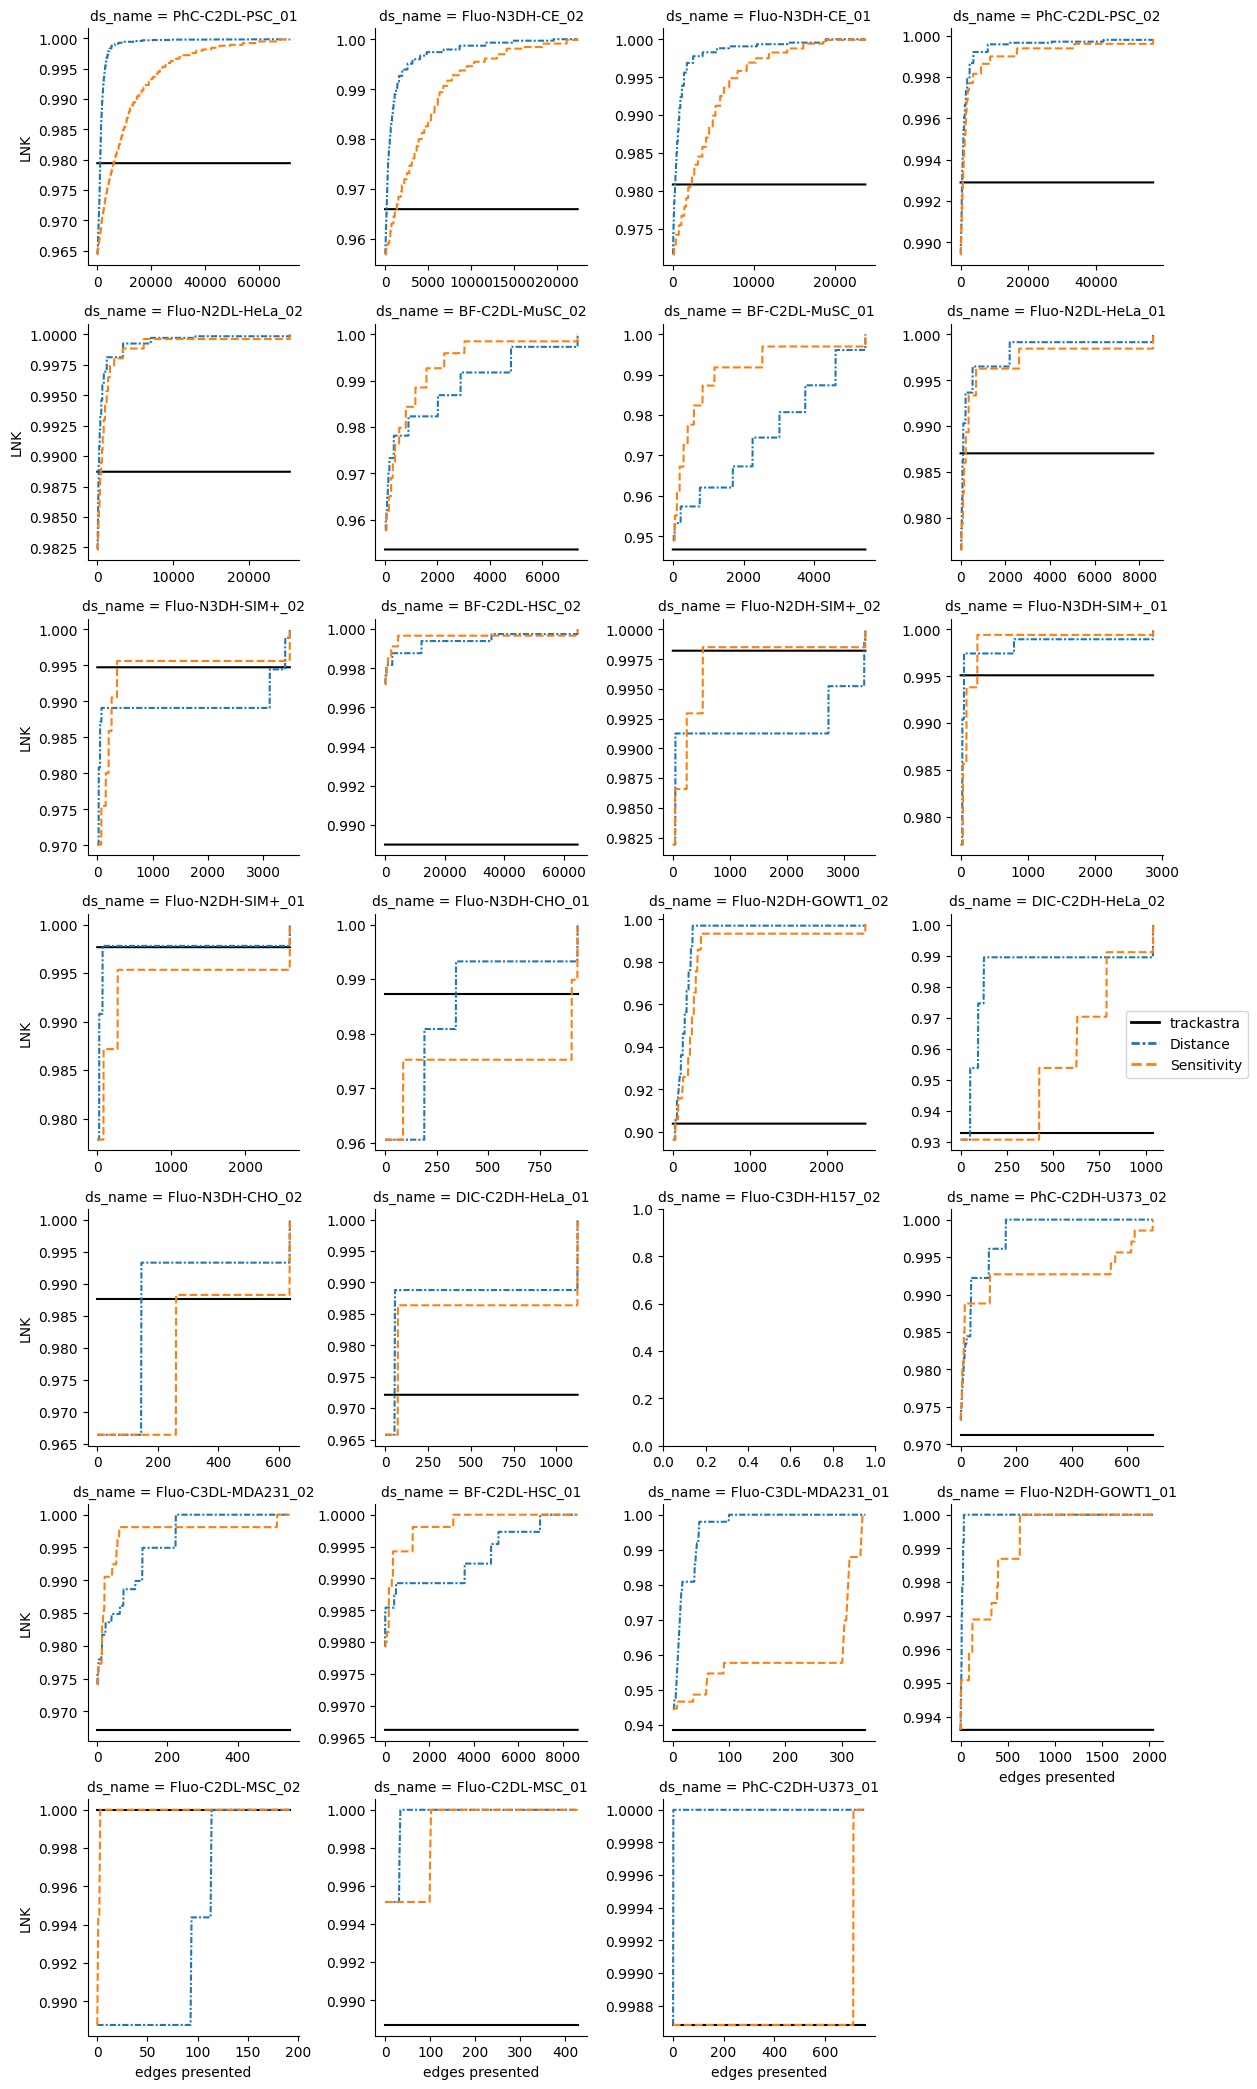

In [3]:
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

grid = sns.FacetGrid(all_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.lineplot, x='feature_distance_presented_rank', y='trackastra_LNK', color='black')
grid.map_dataframe(sns.lineplot, x='feature_distance_presented_rank', y='feature_distance_LNK', color=sns.color_palette()[0], linestyle=(0, (3, 1, 1, 1)))
grid.map_dataframe(sns.lineplot, x='sensitivity_diff_presented_rank', y='sensitivity_diff_LNK', color=sns.color_palette()[1], linestyle='--')


# Create custom legend labels
custom_lines = [
    Line2D([0], [0], color='black', lw=2),
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, linestyle=(0, (3, 1, 1, 1))),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, linestyle='--'),
]

# Add legend to the figure
grid.figure.legend(custom_lines, ['trackastra', 'Distance', 'Sensitivity'], loc='center right', bbox_to_anchor=(1.05, 0.5))
grid.set_xlabels('edges presented')
grid.set_ylabels('LNK')

In [4]:
all_df.groupby('ds_name').agg({'feature_distance_LNK': 'max', 'sensitivity_diff_LNK': 'max'})

,feature_distance_LNK,sensitivity_diff_LNK
ds_name,,
BF-C2DL-HSC_01,1.000000,1.000000
BF-C2DL-HSC_02,0.999984,0.999984
BF-C2DL-MuSC_01,1.000000,1.000000
BF-C2DL-MuSC_02,1.000000,1.000000
DIC-C2DH-HeLa_01,1.000000,1.000000
DIC-C2DH-HeLa_02,1.000000,1.000000
Fluo-C2DL-MSC_01,1.000000,1.000000
Fluo-C2DL-MSC_02,1.000000,1.000000
Fluo-C3DL-MDA231_01,1.000000,1.000000


In [46]:
def find_first_bigger(group):
    condition = group['feature_distance_LNK'] >= group['trackastra_LNK']
    first_valid_row = group.loc[condition].iloc[0]
    return pd.Series({
        'distance_n_edges': first_valid_row['feature_distance_presented_rank'],
        'sensitivity_n_edges': first_valid_row['sensitivity_diff_presented_rank']
    })

result = all_df.groupby('ds_name').apply(find_first_bigger).reset_index()
result['distance_prop'] = result.apply(lambda row: row['distance_n_edges'] / all_df[all_df['ds_name'] == row['ds_name']].shape[0], axis=1)
result['sensitivity_prop'] = result.apply(lambda row: row['sensitivity_n_edges'] / all_df[all_df['ds_name'] == row['ds_name']].shape[0], axis=1)
result['min_edges'] = result[['distance_n_edges', 'sensitivity_n_edges']].min(axis=1)
result['min_prop'] = result[['distance_prop', 'sensitivity_prop']].min(axis=1)

result.sort_values(by='min_prop')

/tmp/ipykernel_2469199/3888474603.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = all_df.groupby('ds_name').apply(find_first_bigger).reset_index()


,ds_name,distance_n_edges,sensitivity_n_edges,distance_prop,sensitivity_prop,min_edges,min_prop
0,BF-C2DL-HSC_01,0,0,0.000000,0.000000,0,0.000000
1,BF-C2DL-HSC_02,0,0,0.000000,0.000000,0,0.000000
2,BF-C2DL-MuSC_01,0,0,0.000000,0.000000,0,0.000000
3,BF-C2DL-MuSC_02,0,0,0.000000,0.000000,0,0.000000
6,Fluo-C2DL-MSC_01,0,0,0.000000,0.000000,0,0.000000
10,Fluo-N2DH-GOWT1_01,0,0,0.000000,0.000000,0,0.000000
9,Fluo-C3DL-MDA231_02,0,0,0.000000,0.000000,0,0.000000
8,Fluo-C3DL-MDA231_01,0,0,0.000000,0.000000,0,0.000000
23,PhC-C2DH-U373_02,0,0,0.000000,0.000000,0,0.000000
22,PhC-C2DH-U373_01,0,0,0.000000,0.000000,0,0.000000


In [48]:
result['min_prop'].describe()

count    26.000000
mean      0.034216
std       0.082514
min       0.000000
25%       0.000000
50%       0.006270
75%       0.014932
max       0.368308
Name: min_prop, dtype: float64

In [10]:
def find_first_1(group):
    condition = group['feature_distance_LNK'] == group['feature_distance_LNK'].max()
    first_valid_row = group.loc[condition].iloc[0]
    return pd.Series({
        'distance_n_edges': first_valid_row['feature_distance_presented_rank'],
        'sensitivity_n_edges': first_valid_row['sensitivity_diff_presented_rank']
    })

result_to_1 = all_df.groupby('ds_name').apply(find_first_1).reset_index()
result_to_1['distance_prop'] = result_to_1.apply(lambda row: row['distance_n_edges'] / all_df[all_df['ds_name'] == row['ds_name']].shape[0], axis=1)
result_to_1['sensitivity_prop'] = result_to_1.apply(lambda row: row['sensitivity_n_edges'] / all_df[all_df['ds_name'] == row['ds_name']].shape[0], axis=1)
result_to_1['min_edges'] = result_to_1[['distance_n_edges', 'sensitivity_n_edges']].min(axis=1)
result_to_1['min_prop'] = result_to_1[['distance_prop', 'sensitivity_prop']].min(axis=1)

result_to_1.sort_values(by='min_prop')

/tmp/ipykernel_2467742/1371050530.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_to_1 = all_df.groupby('ds_name').apply(find_first_1).reset_index()


,ds_name,distance_n_edges,sensitivity_n_edges,distance_prop,sensitivity_prop,min_edges,min_prop
19,PhC-C2DH-U373_01,2,713,0.002628,0.936925,2,0.002628
7,Fluo-C2DL-MSC_02,114,1,0.590674,0.005181,1,0.005181
0,BF-C2DL-HSC_01,6982,78,0.804841,0.008991,78,0.008991
10,Fluo-N2DH-GOWT1_01,34,397,0.016667,0.194608,34,0.016667
9,Fluo-C3DL-MDA231_02,224,14,0.407273,0.025455,14,0.025455
13,Fluo-N2DH-SIM+_02,3382,97,0.999704,0.028673,97,0.028673
6,Fluo-C2DL-MSC_01,34,379,0.079625,0.887588,34,0.079625
8,Fluo-C3DL-MDA231_01,100,37,0.296736,0.109792,37,0.109792
5,DIC-C2DH-HeLa_02,1040,124,1.017613,0.121331,124,0.121331
20,PhC-C2DH-U373_02,163,106,0.234870,0.152738,106,0.152738


In [49]:
# what percent of edges do we need to look at before we've corrected the majority of remaining errors
ds_names = []
presented_prop_before_majority_dist = []
presented_prop_before_majority_sens = []
for ds_name in all_df.ds_name.unique():
    ds_names.append(ds_name)
    ds_edges = all_df[(all_df.ds_name == ds_name) & (all_df.u != -1) & (all_df.v != -1)]

    ds_edges_distance_sorted = ds_edges.sort_values(by='feature_distance_presented_rank')

    # what proportion of remaining errors have been presented at each edge
    ds_edges_distance_sorted['prop_wrong_presented'] = ds_edges_distance_sorted.solution_incorrect.cumsum() / ds_edges.solution_incorrect.sum()
    # when do we first hit 0.5
    majority_index = ds_edges_distance_sorted.loc[ds_edges_distance_sorted.prop_wrong_presented > 0.5].iloc[0]

    # how many edges have we presented up to this point
    presented_so_far_distance = majority_index.feature_distance_presented_rank
    presented_so_far_distance_prop = presented_so_far_distance / ds_edges_distance_sorted.shape[0]
    presented_prop_before_majority_dist.append(presented_so_far_distance_prop)

    ds_edges_sensitivity_sorted = ds_edges.sort_values(by='sensitivity_diff_presented_rank')
    ds_edges_sensitivity_sorted['prop_wrong_presented'] = ds_edges_sensitivity_sorted.solution_incorrect.cumsum() / ds_edges.solution_incorrect.sum()
    majority_index = ds_edges_sensitivity_sorted.loc[ds_edges_sensitivity_sorted.prop_wrong_presented > 0.5].iloc[0]
    presented_so_far_sensitivity = majority_index.sensitivity_diff_presented_rank
    presented_so_far_sensitivity_prop = presented_so_far_sensitivity / ds_edges_sensitivity_sorted.shape[0]
    presented_prop_before_majority_sens.append(presented_so_far_sensitivity_prop)

presented_props = pd.DataFrame({
    'ds_name': ds_names,
    'presented_prop_before_majority_dist': presented_prop_before_majority_dist,
    'presented_prop_before_majority_sens': presented_prop_before_majority_sens
})
presented_props['min_prop'] = presented_props[['presented_prop_before_majority_dist', 'presented_prop_before_majority_sens']].min(axis=1)
presented_props.sort_values(by='min_prop')
presented_props

    

,ds_name,presented_prop_before_majority_dist,presented_prop_before_majority_sens,min_prop
0,Fluo-N3DH-SIM+_01,0.014321,0.025847,0.014321
1,Fluo-N3DH-SIM+_02,0.021564,0.058942,0.021564
2,Fluo-C3DL-MDA231_01,0.050595,0.922619,0.050595
3,Fluo-C3DL-MDA231_02,0.074681,0.080146,0.074681
4,Fluo-N2DH-GOWT1_01,0.005395,0.128494,0.005395
5,Fluo-N2DH-GOWT1_02,0.059113,0.097701,0.059113
6,PhC-C2DH-U373_01,0.003947,0.961842,0.003947
7,PhC-C2DH-U373_02,0.021645,0.803752,0.021645
8,Fluo-N2DL-HeLa_01,0.014165,0.027284,0.014165
9,Fluo-N2DL-HeLa_02,0.015064,0.032454,0.015064


In [50]:
presented_props.describe()

,presented_prop_before_majority_dist,presented_prop_before_majority_sens,min_prop
count,26.000000,26.000000,26.000000
mean,0.102864,0.200785,0.047389
std,0.154855,0.279519,0.050271
min,0.003947,0.015348,0.003947
25%,0.017464,0.034959,0.015418
50%,0.033902,0.078093,0.028852
75%,0.081844,0.191440,0.056984
max,0.593750,0.961842,0.197802


In [30]:
ds_names = []
prop_errors_distance = []
prop_errors_sens = []
prop_errors_in_sample_distance = []
prop_errors_in_sample_sens = []
for ds_name in all_df.ds_name.unique():
    ds_names.append(ds_name)
    ds_edges = all_df[(all_df.ds_name == ds_name) & (all_df.u != -1) & (all_df.v != -1)]
    first_one_percent_distance = ds_edges.feature_distance_presented_rank.quantile(0.02)
    first_one_percent_edges_distance = ds_edges[ds_edges.feature_distance_presented_rank <= first_one_percent_distance]
    num_incorrect_distance = first_one_percent_edges_distance[first_one_percent_edges_distance.solution_incorrect].solution_incorrect.sum()
    num_total_incorrect_distance = ds_edges[ds_edges.solution_incorrect].solution_incorrect.sum()
    prop_of_all_in_first_one_percent = num_incorrect_distance / num_total_incorrect_distance
    prop_errors_distance.append(prop_of_all_in_first_one_percent)
    prop_incorrect_in_one_percent_distance = num_incorrect_distance/len(first_one_percent_edges_distance)
    prop_errors_in_sample_distance.append(prop_incorrect_in_one_percent_distance)

    first_one_percent_sens = ds_edges.sensitivity_diff_presented_rank.quantile(0.02)
    first_one_percent_edges_sens = ds_edges[ds_edges.sensitivity_diff_presented_rank <= first_one_percent_sens]
    num_incorrect_sens = first_one_percent_edges_sens[first_one_percent_edges_sens.solution_incorrect].solution_incorrect.sum()
    num_total_incorrect_sens = ds_edges[ds_edges.solution_incorrect].solution_incorrect.sum()
    prop_of_all_in_first_one_percent_sens = num_incorrect_sens / num_total_incorrect_sens
    prop_errors_sens.append(prop_of_all_in_first_one_percent_sens)
    prop_incorrect_in_one_percent_sens = num_incorrect_sens/len(first_one_percent_edges_sens)
    prop_errors_in_sample_sens.append(prop_incorrect_in_one_percent_sens)


    
first_one_percent_prop = pd.DataFrame({'ds_name': ds_names, 'prop_errors_distance': prop_errors_distance, 'prop_errors_sens': prop_errors_sens, 'prop_errors_in_sample_distance': prop_errors_in_sample_distance, 'prop_errors_in_sample_sens': prop_errors_in_sample_sens})
first_one_percent_prop['max_prop'] = first_one_percent_prop[['prop_errors_distance', 'prop_errors_sens']].max(axis=1)
first_one_percent_prop['max_prop_in_sample'] = first_one_percent_prop[['prop_errors_in_sample_distance', 'prop_errors_in_sample_sens']].max(axis=1)
first_one_percent_prop.sort_values(by='max_prop_in_sample', ascending=False)

,ds_name,prop_errors_distance,prop_errors_sens,prop_errors_in_sample_distance,prop_errors_in_sample_sens,max_prop,max_prop_in_sample
0,Fluo-N3DH-SIM+_01,0.716049,0.419753,1.000000,0.586207,0.716049,1.000000
1,Fluo-N3DH-SIM+_02,0.472973,0.162162,1.000000,0.342857,0.472973,1.000000
10,Fluo-C2DL-MSC_02,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
5,Fluo-N2DH-GOWT1_02,0.219512,0.136585,0.918367,0.571429,0.219512,0.918367
16,BF-C2DL-MuSC_02,0.480916,0.175573,0.857143,0.312925,0.480916,0.857143
21,PhC-C2DL-PSC_01,0.582600,0.145650,0.834734,0.208683,0.582600,0.834734
19,Fluo-N2DH-SIM+_01,0.571429,0.300000,0.769231,0.403846,0.571429,0.769231
7,PhC-C2DH-U373_02,0.500000,0.333333,0.642857,0.428571,0.500000,0.642857
8,Fluo-N2DL-HeLa_01,0.577540,0.411765,0.624277,0.445087,0.577540,0.624277
11,DIC-C2DH-HeLa_01,0.358974,0.333333,0.608696,0.565217,0.358974,0.608696


In [31]:
first_one_percent_prop.describe()

,prop_errors_distance,prop_errors_sens,prop_errors_in_sample_distance,prop_errors_in_sample_sens,max_prop,max_prop_in_sample
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.393723,0.269442,0.450161,0.324359,0.455108,0.532391
std,0.279337,0.228431,0.348480,0.247982,0.278218,0.318197
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.215019,0.122347,0.089223,0.094235,0.243089,0.312383
50%,0.384615,0.212670,0.441176,0.333333,0.472973,0.550459
75%,0.569422,0.393527,0.706044,0.465190,0.580070,0.801982
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
result_to_1.min_prop.describe()

count    23.000000
mean      0.374134
std       0.351475
min       0.002628
25%       0.054149
50%       0.188846
75%       0.633159
max       0.953507
Name: min_prop, dtype: float64

In [47]:
result.min_prop.describe()

count    26.000000
mean      0.034216
std       0.082514
min       0.000000
25%       0.000000
50%       0.006270
75%       0.014932
max       0.368308
Name: min_prop, dtype: float64

In [24]:
result[result.min_prop > 0]['min_prop'].describe()

count    14.000000
mean      0.062209
std       0.106082
min       0.004140
25%       0.007771
50%       0.014443
75%       0.048643
max       0.368308
Name: min_prop, dtype: float64

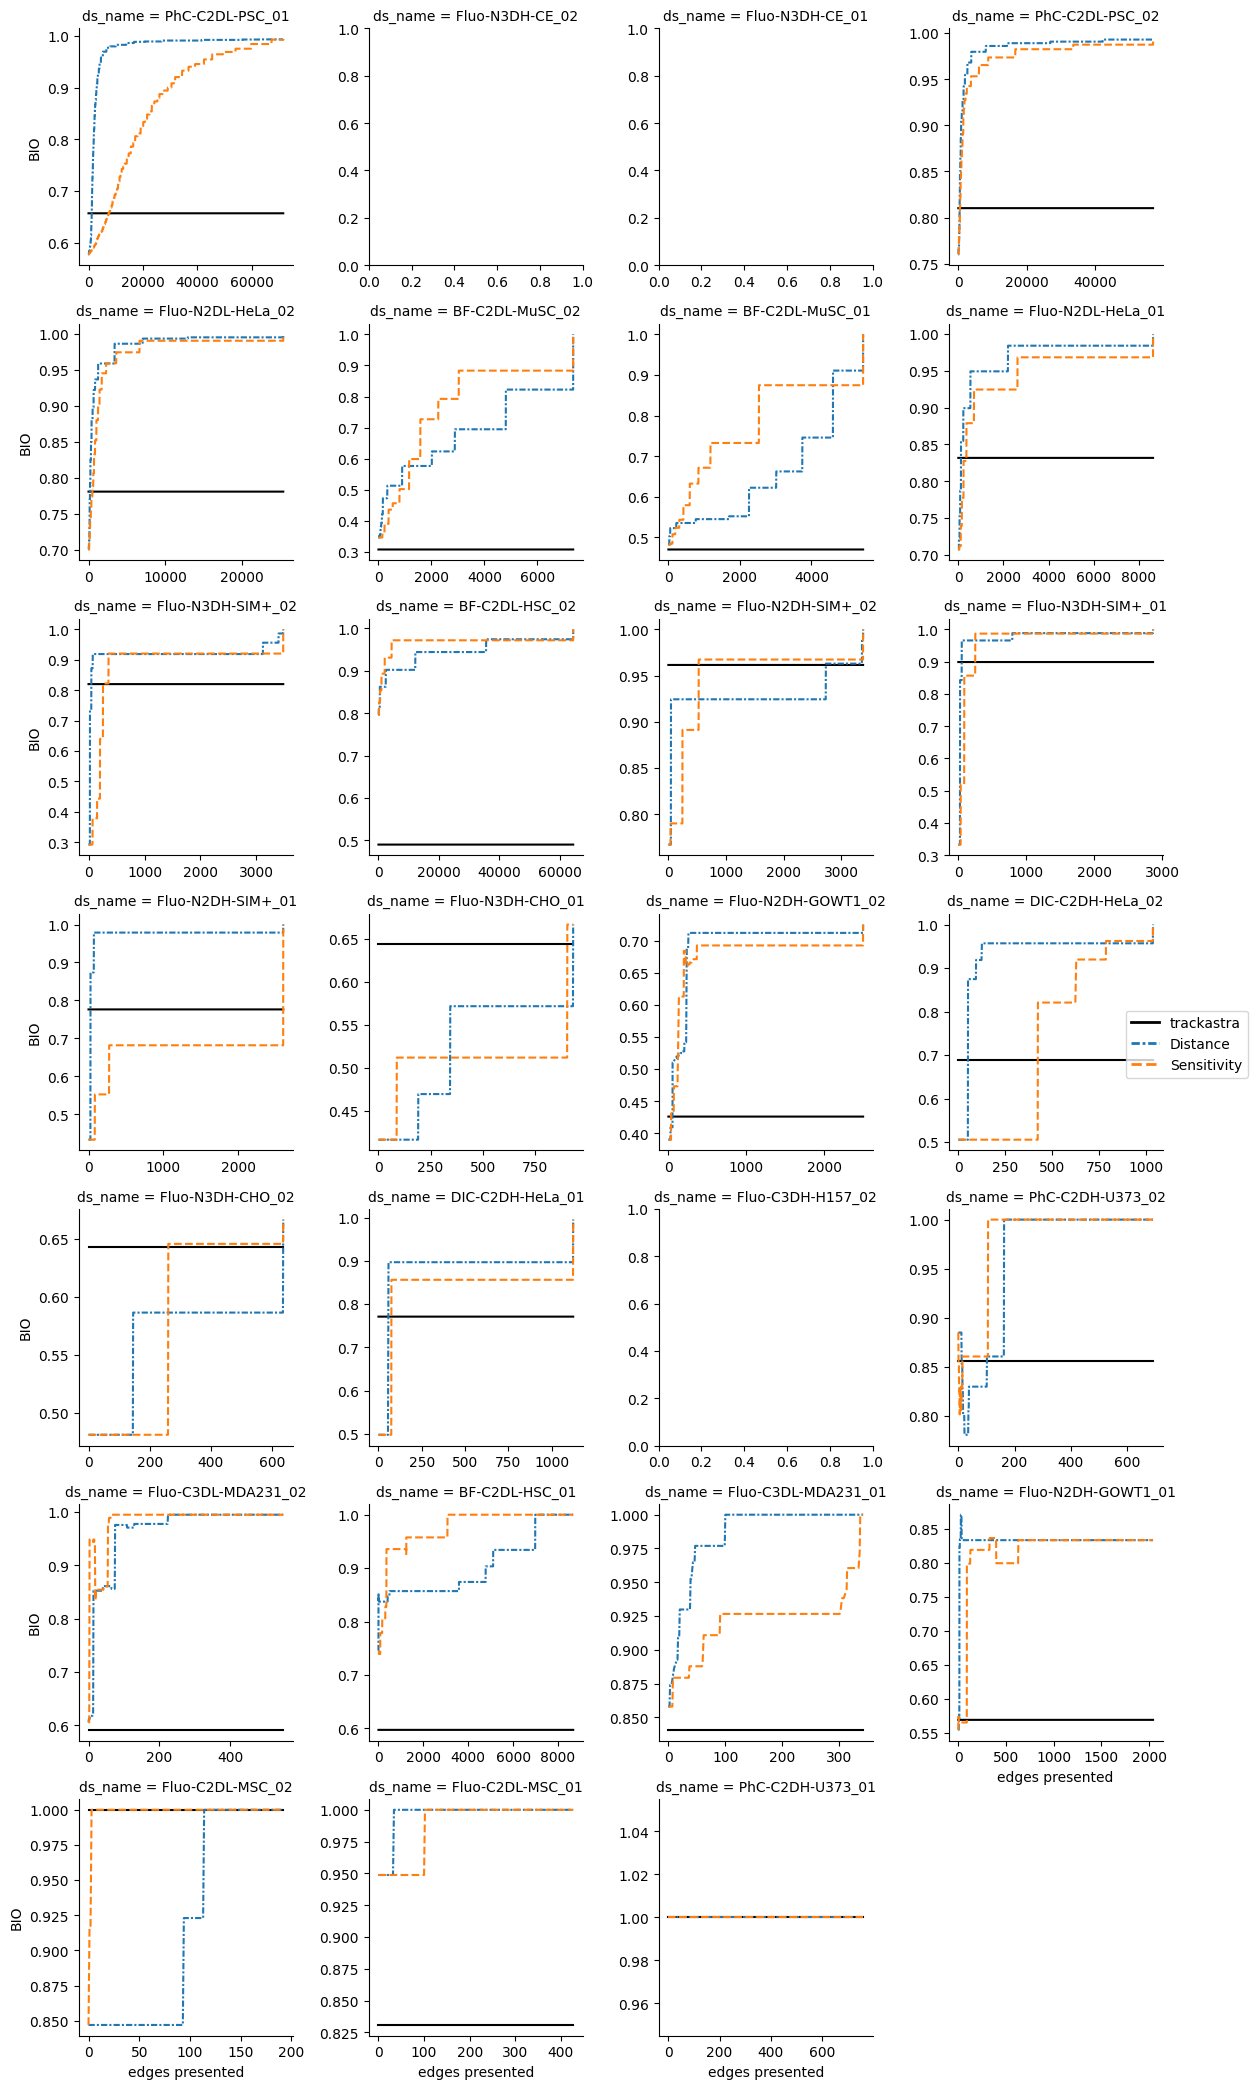

In [25]:
import seaborn as sns

grid = sns.FacetGrid(all_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.lineplot, x='feature_distance_presented_rank', y='trackastra_BIO(0)', color='black')
grid.map_dataframe(sns.lineplot, x='feature_distance_presented_rank', y='feature_distance_BIO(0)', color=sns.color_palette()[0], linestyle=(0, (3, 1, 1, 1)))
grid.map_dataframe(sns.lineplot, x='sensitivity_diff_presented_rank', y='sensitivity_diff_BIO(0)', color=sns.color_palette()[1], linestyle=('--'))


# Create custom legend labels
custom_lines = [
    Line2D([0], [0], color='black', lw=2),
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, linestyle=(0, (3, 1, 1, 1))),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, linestyle='--'),
]

# Add legend to the figure
grid.figure.legend(custom_lines, ['trackastra', 'Distance', 'Sensitivity'], loc='center right', bbox_to_anchor=(1.05, 0.5))
grid.set_xlabels('edges presented')
grid.set_ylabels('BIO')

In [ ]:
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

grid = sns.FacetGrid(all_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.lineplot, x='distance_edges_presented', y='trackastra_LNK', color='black')

grid.map_dataframe(sns.lineplot, x='distance_ws_edges_presented', y='distance_ws_LNK', color=sns.color_palette()[0], linestyle=(0, (3, 1, 1, 1)))
grid.map_dataframe(sns.lineplot, x='sensitivity_diff_ws_edges_presented', y='sensitivity_diff_ws_LNK', color=sns.color_palette()[1], linestyle='--')


# Create custom legend labels
custom_lines = [
    Line2D([0], [0], color='black', lw=2),
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, linestyle=(0, (3, 1, 1, 1))),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, linestyle='--'),
]

# Add legend to the figure
grid.figure.legend(custom_lines, ['trackastra', 'Distance', 'Sensitivity'], loc='center right', bbox_to_anchor=(1.05, 0.5))
grid.set_xlabels('edges presented')
grid.set_ylabels('LNK')

In [ ]:
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

grid = sns.FacetGrid(all_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.lineplot, x='distance_edges_presented', y='trackastra_BIO(0)', color='black')

grid.map_dataframe(sns.lineplot, x='distance_ws_edges_presented', y='distance_ws_BIO(0)', color=sns.color_palette()[0], linestyle=(0, (3, 1, 1, 1)))
grid.map_dataframe(sns.lineplot, x='sensitivity_diff_ws_edges_presented', y='sensitivity_diff_ws_BIO(0)', color=sns.color_palette()[1], linestyle='--')


# Create custom legend labels
custom_lines = [
    Line2D([0], [0], color='black', lw=2),
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, linestyle=(0, (3, 1, 1, 1))),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, linestyle='--'),
]

# Add legend to the figure
grid.figure.legend(custom_lines, ['trackastra', 'Distance', 'Sensitivity'], loc='center right', bbox_to_anchor=(1.05, 0.5))
grid.set_xlabels('edges presented')
grid.set_ylabels('BIO')